# Testing the different types of scalers with logistic regression

- Do Postgresql instead of pickling
---

In [1]:
import io, requests

import datetime
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import xgboost as xgb

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import NuSVR
from sklearn.metrics import log_loss

###############################################################################
# Undersampling did not show any appreciable improvement in model performance #
###############################################################################

# from imblearn.under_sampling import TomekLinks # removed 5ish samples and only made a marginal improvement to the logloss values
# from imblearn.under_sampling import ClusterCentroids # wasn't useful
# from imblearn.under_sampling import NeighbourhoodCleaningRule # made model marginally worse and took significantly longer
# from imblearn.under_sampling import InstanceHardnessThreshold #kept getting errors
# from imblearn.under_sampling import EditedNearestNeighbours#did not remove any samples
# from imblearn.under_sampling import AllKNN#did not remove any samples
# from imblearn.under_sampling import CondensedNearestNeighbour#crashed after using all ram
# from imblearn.under_sampling import NearMiss# marginally worse after running NearMiss(version=2, n_jobs=2, sampling_strategy=sampling_val)

## Loading the data

In [2]:
def dummy_vars(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    # trt_cp is a control and has no MOA, ctl_vehicle indicates a real test
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    # create columns ['cp_type_24', 'cp_type_48', 'cp_type_72'] which are one hot encoded based on cp_time
    df['cp_type_24'] = df['cp_time'].astype(str) == '24'
    df['cp_type_48'] = df['cp_time'].astype(str) == '48'
    df['cp_type_72'] = df['cp_time'].astype(str) == '72'
    df.drop(columns=['sig_id','cp_time'], inplace = True)
    return df

In [3]:
def load_files():
    # Train Features
    train_features = pd.read_csv('train_features.csv')
    train_features = dummy_vars(train_features)
    print('train_features loaded')

    # Train Targets
    train_targets = pd.read_csv('train_targets_scored.csv')
    train_targets.drop(columns=['sig_id'], inplace = True)
    print('train_targets loaded')

    # Test Features
    test_features = pd.read_csv('test_features.csv')
    test_features = dummy_vars(test_features)
    #test_features = pd.DataFrame(power_transform(test_features, method='yeo-johnson'))
    print('test_features loaded')

    # Sample Submission DF (Targets)
    ss_lr = pd.read_csv('sample_submission.csv')
    ss_lr.drop(columns=['sig_id'], inplace = True)
    print('ss_lr loaded')

    print('done!')

    return train_features, train_targets, test_features, ss_lr

## Data Pipeline

In [4]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

In [5]:
def k_fold_fit_pred(model_train_num, column, x_test, target_vals, N_SPLITS, res, ss):
    for rand_state in range(model_train_num):
        # train the model for each one of the random states 
        skf = StratifiedKFold(n_splits = N_SPLITS, random_state = rand_state, shuffle = True)

        for (train, val) in skf.split(target_vals, target_vals):
        # for each of the train/validate splits...
            scaler = StandardScaler()

            x_train = X[train, column].reshape(-1, 1).astype(float)
            y_train = target_vals[train].astype(float)

            x_train = scaler.fit_transform(x_train)

            x_val = X[val, column].reshape(-1, 1).astype(float)
            y_val = target_vals[val].astype(float)

            x_val = scaler.transform(x_val)

            model.fit(x_train, y_train)

            try:
                ss_pred_vals = model.predict_proba(x_test[:, column].reshape(-1,1))[:,1]
            except: # For the tree based models
                ss_pred_vals = model.predict(x_test[:, column].reshape(-1,1))
            ss.loc[:, train_targets.columns[column]] += (
                ss_pred_vals / (N_SPLITS * model_train_num))

            try:
                res_pred_vals = model.predict_proba(x_val)[:,1]
            except: # For the tree based models
                res_pred_vals = model.predict(x_val)
            res.loc[val, train_targets.columns[column]] += (
                res_pred_vals / model_train_num)

    return res, ss

In [6]:
# cols = [c for c in ss_lr.columns.values]
def run_score(train_targets, X, x_test, res, ss, logloss_vals):
# train_targets is the training targets
# X is the train features
# x_test is the holdout set of features
# ss_ is blank since it's the empty sample submission predictions

    N_SPLITS = 5 # number of k-fold splits
    model_train_num = 2 # number of random states the model is trained on for each target

    for column in tqdm(range(train_targets.shape[1])):
    # create a model for each of the targets
        start_time = time()
        target_vals = train_targets.values[:, column]

        if target_vals.sum() >= 5:
        # split if there's enough positive target values
            res, ss = k_fold_fit_pred(model_train_num, column, x_test, target_vals, N_SPLITS, res, ss)

        score = log_loss(
            train_targets.loc[:, train_targets.columns[column]],
            res.loc[:, train_targets.columns[column]])
        feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
        #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
        target_counts.append(np.sum(target_vals))
        logloss_vals.append(score)

    print(f'Log Loss: {log_loss_metric(train_targets, res)}')

    # these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
    res.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
    ss.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
    print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res)}\n\n')
    
    return res, ss, logloss_vals

In [7]:
train_features, train_targets, test_features, ss_lr = load_files()

# g_tags = [g for g in list(train_features.columns) if g[0]+g[1] == 'g-']
# c_tags = [c for c in list(train_features.columns) if c[0]+c[1] == 'c-']

# train_features[c_tags] = scaler.fit_transform(train_features[c_tags])
# test_features[c_tags] = scaler.fit_transform(test_features[c_tags])

# train_features[g_tags] = scaler.fit_transform(train_features[g_tags])
# test_features[g_tags] = scaler.fit_transform(test_features[g_tags])


X = train_features.values[:,:]
x_test = test_features.values[:,:]

#This is for the sample_submission.csv df
ss_lr.loc[:, train_targets.columns] = 0

#These are the target values which are being predicted and tested
res_lr = train_targets.copy()
res_lr.loc[:, train_targets.columns] = 0

cols = ss_lr.columns.values

train_features loaded
train_targets loaded
test_features loaded
ss_lr loaded
done!


## Running and Evaluating the Models


Log Loss: 0.020385199315341
After manually eliminating control groups: 0.020100039338947443




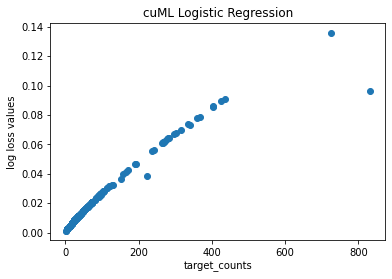

In [8]:

#model = LogisticRegression(C = 128, max_iter = 100000) #128 is the ideal value for cuml using standard scaler
try:
    res_lr = pd.from_pickle('pickles/res_lr.p')
    ss_lr = pd.from_pickle('pickles/ss_lr.p')
except:
    from cuml.linear_model import LogisticRegression
    for i in [256]: # left for further hyperparameter tuning
        model = LogisticRegression(C = 128, max_iter = 100000)
        target_counts = []
        logistic_regr_loss_vals = []
        ss_lr.loc[:, train_targets.columns] = 0
        res_lr.loc[:, train_targets.columns] = 0
        res_lr, ss_lr, logistic_regr_loss_vals = run_score(train_targets, X, x_test, res_lr, ss_lr, logistic_regr_loss_vals)
    plt.scatter(target_counts,logistic_regr_loss_vals)
    plt.xlabel('target_counts')
    plt.ylabel('log loss values')
    plt.title('cuML Logistic Regression')
    plt.show()
    res_lr.to_pickle('pickles/res_cuml_lr.p')
    ss_lr.to_pickle('pickles/ss_cuml_lr.p')


Log Loss: 0.02032292674082123
After manually eliminating control groups: 0.020062833012380658




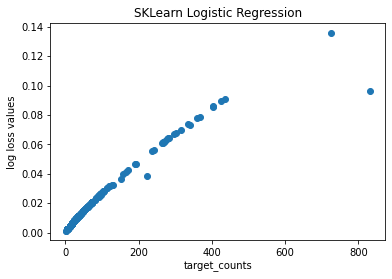

In [9]:
#model = SVR(kernel='poly', gamma='auto', C=200, cache_size=14000) #had estimated finish time of 12 hrs
#model = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)# slooowwwww
#model = NuSVR(C=1, nu=0.1) # The default kernel is RBF
#model = LogisticRegression(C = 128, max_iter = 100000) #128 is the ideal value for cuml using standard scaler
#model = LogisticRegression(C = 128, solver = 'lbfgs', warm_start=True, n_jobs=-1 max_iter = 10000)
try:
    res_lr = pd.from_pickle('pickles/res_lr.p')
    ss_lr = pd.from_pickle('pickles/ss_lr.p')
except:
    from sklearn.linear_model import LogisticRegression
    for i in [256]: # left for further hyperparameter tuning
        model = LogisticRegression(C = i, solver = 'saga', warm_start=True, n_jobs=-1, max_iter = 100000)
        target_counts = []
        logistic_regr_loss_vals = []
        ss_lr.loc[:, train_targets.columns] = 0
        res_lr.loc[:, train_targets.columns] = 0
        res_lr, ss_lr, logistic_regr_loss_vals = run_score(train_targets, X, x_test, res_lr, ss_lr, logistic_regr_loss_vals)
    plt.scatter(target_counts,logistic_regr_loss_vals)
    plt.xlabel('target_counts')
    plt.ylabel('log loss values')
    plt.title('SKLearn Logistic Regression')
    plt.show()
    res_lr.to_pickle('pickles/res_lr.p')
    ss_lr.to_pickle('pickles/ss_lr.p')

In [ ]:
try:
    res_rfr = pd.from_pickle('pickles/res_rfr.p')
    ss_rfr = pd.from_pickle('pickles/ss_rfr.p')
except:
    from sklearn.ensemble import RandomForestRegressor
    for i in [1]: # left for further hyperparameter tuning
        model = RandomForestRegressor(max_depth=3, random_state=42)
        target_counts = []
        rfr_loss_vals = []
        ss_rfr = ss_lr.copy()
        res_rfr = res_lr.copy()
        ss_rfr.loc[:, train_targets.columns] = 0
        res_rfr.loc[:, train_targets.columns] = 0
        res_rfr, ss_rfr, rfr_loss_vals = run_score(train_targets, X, x_test, res_rfr, ss_rfr, rfr_loss_vals)
    plt.scatter(target_counts, rfr_loss_vals)
    plt.xlabel('target_counts')
    plt.ylabel('log loss values')
    plt.title('Random Forest Regression')
    plt.show()
    res_rfr.to_pickle('pickles/res_rfr.p')
    ss_rfr.to_pickle('pickles/ss_rfr.p')

In [ ]:
try:
    res_linsvr = pd.read_pickle('pickles/res_linsvr')
    ss_linsvr = pd.read_pickle('pickles/ss_linsvr')
except:
    from sklearn.svm import LinearSVR
    for i in [1]: # left for further hyperparameter tuning
        model = LinearSVR(random_state = 42, C=16, dual=False, loss='squared_epsilon_insensitive', tol=1e-5)
        target_counts = []
        linsvr_logloss_vals = []
        ss_linsvr = ss_lr.copy()
        res_linsvr = res_lr.copy()
        ss_linsvr.loc[:, train_targets.columns] = 0
        res_linsvr.loc[:, train_targets.columns] = 0
        print(f'intercept_scaling = {i}')
        res_linsvr, ss_linsvr, linsvr_loss_vals = run_score(
            train_targets, X, x_test, res_linsvr, ss_linsvr, linsvr_logloss_vals)
    plt.scatter(target_counts,linsvr_logloss_vals)
    plt.xlabel('target_counts')
    plt.ylabel('log loss values')
    plt.title('LinearSVR')
    plt.show()
    res_linsvr.to_pickle('pickles/res_linsvr')
    ss_linsvr.to_pickle('pickles/ss_linsvr')

In [ ]:
try:
    res_nusvr = pd.read_pickle('pickles/res_nusvr')
    ss_nusvr = pd.read_pickle('pickles/ss_nusvr')
except:
    from sklearn.svm import NuSVR
    for i in [1]: # left for further hyperparameter tuning
        model = NuSVR(kernel='poly', degree=2, C=1, tol=1e-3, cache_size=2024, max_iter=10000)
        target_counts = []
        nusvr_logloss_vals = []
        ss_nusvr = ss_lr.copy()
        res_nusvr = res_lr.copy()
        ss_nusvr.loc[:, train_targets.columns] = 0
        res_nusvr.loc[:, train_targets.columns] = 0
        print(f'intercept_scaling = {i}')
        res_nusvr, ss_nusvr, nusvr_loss_vals = run_score(
            train_targets, X, x_test, res_nusvr, ss_nusvr, nusvr_logloss_vals)
    plt.scatter(target_counts,nusvr_logloss_vals)
    plt.xlabel('target_counts')
    plt.ylabel('log loss values')
    plt.title('nuSVR')
    plt.show()
    res_nusvr.to_pickle('pickles/res_nusvr')
    ss_nusvr.to_pickle('pickles/ss_nusvr')

## Generating the Baseline Model Score
___
This was used to benchmark the models and gain a sense of each model'd overall performance

In [ ]:
zeros_target_counts = []
zeros_loss_vals = []
res_zeros = res_lr.copy()
res_zeros.loc[:, train_targets.columns] = 0
for i in range(res_zeros.shape[1]):
    loss = log_loss(train_targets.iloc[:,i], res_zeros.iloc[:,i])
    zeros_loss_vals.append(loss)
    zeros_target_counts.append(np.sum(train_targets.iloc[:,i]))
# log loss score is the same for all zeros or the average values per column

## Graphing

In [16]:
import pickle
import os
# Try loading the graph data. If it isn't found generate it
try:
    graph_data = pickle.load(open('pickles/graph_data.p','rb'))
    target_counts = graph_data[0]
    nusvr_logloss_vals = graph_data[1]
    linsvr_loss_vals = graph_data[2]
    logistic_regr_loss_vals = graph_data[3]
    rfr_loss_vals = graph_data[4]
    print('loaded graph data')
except:
    graph_data = [target_counts,nusvr_logloss_vals,linsvr_loss_vals,logistic_regr_loss_vals,rfr_loss_vals]
    pickle.dump(graph_data,open('pickles/graph_data.p','wb'))
    print('saved graph data')

if not os.path.exists("figures"):
    os.mkdir("figures")

loaded graph data


In [27]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly
import os

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=zeros_target_counts,
    y=zeros_loss_vals,
    name='all zeros',
    mode='lines',
    hovertemplate=['' for i in range(len(train_targets.columns))])
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=nusvr_logloss_vals,
    name='NuSVR',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=linsvr_loss_vals,
    name='linSVR',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=logistic_regr_loss_vals,
    name='Logistic Regression',
    mode='markers',
    hovertemplate = train_targets.columns)
)
# fig.add_trace(go.Scatter(
#     x=target_counts,
#     y=xgb_loss_vals,
#     name='XGBoost',
#     mode='markers',
#     hovertemplate = train_targets.columns)
# )
fig.add_trace(go.Scatter(
    x=target_counts,
    y=rfr_loss_vals,
    name='Random Forest Regression',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.update_layout(
    title='<b>Model Evaluation for all Targets</b>',
    title_x=0.5,
    xaxis_title='Size of Minority Class (out of 20,000)',
    yaxis_title='Log Loss Scores',
    xaxis_showgrid = False,
    yaxis_showgrid = False,
    yaxis_range=[0,0.2],
    xaxis_range=[0,850],
    hoverlabel_align = 'right',
    paper_bgcolor='rgba(154,186,211,0.8)',
    plot_bgcolor='rgba(232,246,252,0.2)'
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='rgba(232,246,252,0.2)')
fig.update_yaxes(showline=True, linewidth=2, linecolor='rgba(232,246,252,0.2)')
fig.show()
    
the_date = str(datetime.datetime.now())[:10]
html_path = 'figures/Plotly_all_logloss_' + the_date + '.html'
plotly.io.write_html(fig, html_path)

In [28]:
#hovertemplate = 
barxvals = np.array([nusvr_logloss_vals[-4:],linsvr_loss_vals[-4:], logistic_regr_loss_vals[-4:], rfr_loss_vals[-4:]]).swapaxes(0,1)
baryvals = ['NuSVR','LinSVR','Logistic Regression','Rand Forest Regression']
colors = ['red','green','purple','orange']

fig = make_subplots(rows=4, cols=1,
    shared_xaxes=True,
    subplot_titles=['VEGFR Inhibitor','Vitamin B','Vitamin D Receptor Agonist','WNT Inhibitor'])
fig.append_trace(
    go.Bar(
    y = baryvals,
    x=barxvals[0],
    hoverinfo = "y",
    marker_color = colors,
    orientation='h'
    ), row=1, col=1)
fig.append_trace(
    go.Bar(
    y = baryvals,
    x=barxvals[1],
    hoverinfo = "y",
    marker_color = colors,
    orientation='h'
    ), row=2, col=1)
fig.append_trace(
    go.Bar(
    y = baryvals,
    x=barxvals[2],
    hoverinfo = "y",
    marker_color = colors,
    orientation='h'
    ), row=3, col=1)
fig.append_trace(
    go.Bar(
    y = baryvals,
    x=barxvals[3],
    hoverinfo = "y",
    marker_color = colors,
    orientation='h'), row=4, col=1)
# Change the bar mode
#fig.update_xaxes(autorange='reversed')
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(
    title='<b>Log Loss Scores for Different MOAs</b>',
    title_x=0.5,
    bargap=0.1,
    showlegend=False,
    paper_bgcolor='rgba(154,186,211,0.8)',
    plot_bgcolor='rgba(232,246,252,0.8)'
)
fig.show()

the_date = str(datetime.datetime.now())[:10]
html_path = 'figures/Plotly_hbarchart_' + the_date + '.html'
plotly.io.write_html(fig, html_path)